In [ ]:

import pandas as pd
import numpy as np
from pckgs.helper import timeseries_to_supervised, PnlCallback
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from pckgs.models import get_model_both_sent
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sb
from pckgs.evaluator import Evaluator

from pckgs.headline_preprocess import HeadlinePreprocess

%load_ext autoreload
%autoreload 2


In [28]:
price = pd.read_csv('../Price/datasets/bitcoin_position_day_20.csv', parse_dates=['Timestamp'])
price.rename(columns={'Timestamp':'date'}, inplace=True)
price.set_index('date', inplace=True)
y = price.loc[:,['down', 'same', 'up']]
x1 = price.drop(['down', 'same', 'up'], axis=1)
x1

,pChange_scaled_t-1,pChange_scaled_t-2,pChange_scaled_t-3,pChange_scaled_t-4,pChange_scaled_t-5,pChange_scaled_t-6,pChange_scaled_t-7,pChange_scaled_t-8,pChange_scaled_t-9,pChange_scaled_t-10,pChange_scaled_t-11,pChange_scaled_t-12,pChange_scaled_t-13,pChange_scaled_t-14,pChange_scaled_t-15,pChange_scaled_t-16,pChange_scaled_t-17,pChange_scaled_t-18,pChange_scaled_t-19,pChange_scaled_t-20
date,,,,,,,,,,,,,,,,,,,,
2015-01-22,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309,0.141311,-0.295625,-0.459500,-0.027349
2015-01-23,0.071202,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309,0.141311,-0.295625,-0.459500
2015-01-24,-0.054621,0.071202,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309,0.141311,-0.295625
2015-01-25,0.211611,-0.054621,0.071202,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309,0.141311
2015-01-26,0.048235,0.211611,-0.054621,0.071202,0.257598,-0.149628,0.035143,0.189588,-0.203272,-0.101704,0.850764,-1.000000,-0.635317,-0.032267,-0.177178,-0.290542,0.194007,-0.047309,-0.047309,-0.047309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,-0.051358,-0.077206,-0.081685,-0.147564,0.149889,-0.072567,-0.023073,-0.120631,0.349592,-0.199869,-0.174645,-0.016419,-0.153680,-0.009940,-0.057564,-0.051972,-0.113264,-0.142308,-0.036103,-0.067498
2019-12-28,-0.016081,-0.051358,-0.077206,-0.081685,-0.147564,0.149889,-0.072567,-0.023073,-0.120631,0.349592,-0.199869,-0.174645,-0.016419,-0.153680,-0.009940,-0.057564,-0.051972,-0.113264,-0.142308,-0.036103
2019-12-29,-0.020335,-0.016081,-0.051358,-0.077206,-0.081685,-0.147564,0.149889,-0.072567,-0.023073,-0.120631,0.349592,-0.199869,-0.174645,-0.016419,-0.153680,-0.009940,-0.057564,-0.051972,-0.113264,-0.142308


In [29]:
# y2 = pd.read_csv('../Price/datasets/pChange.csv', parse_dates=['Timestamp'], index_col='Timestamp')
# y2 = y2.reindex(y.index)
# y2

In [30]:
#read headline sentiment
sentiment = pd.read_csv('../Text/datasets/headline_sentiment_mean.csv', index_col='date', parse_dates=['date'])

sentiment_score = timeseries_to_supervised(sentiment, 'sentiment_score', lag=21)
sentiment_score.dropna(inplace=True)
sentiment_score.drop('sentiment_score_t', axis=1, inplace=True)
sentiment_score = sentiment_score.reindex(y.index).ffill().bfill()

x2 = sentiment_score
x2

,sentiment_score_t-1,sentiment_score_t-2,sentiment_score_t-3,sentiment_score_t-4,sentiment_score_t-5,sentiment_score_t-6,sentiment_score_t-7,sentiment_score_t-8,sentiment_score_t-9,sentiment_score_t-10,sentiment_score_t-11,sentiment_score_t-12,sentiment_score_t-13,sentiment_score_t-14,sentiment_score_t-15,sentiment_score_t-16,sentiment_score_t-17,sentiment_score_t-18,sentiment_score_t-19,sentiment_score_t-20
date,,,,,,,,,,,,,,,,,,,,
2015-01-22,0.116490,-0.129169,0.164252,0.082091,0.067433,0.038339,0.194653,0.028789,-0.067296,-0.052945,0.114822,0.142415,-0.061513,-0.032284,-0.096522,-0.167775,-0.114472,0.025266,-0.029244,0.057121
2015-01-23,0.058076,0.116490,-0.129169,0.164252,0.082091,0.067433,0.038339,0.194653,0.028789,-0.067296,-0.052945,0.114822,0.142415,-0.061513,-0.032284,-0.096522,-0.167775,-0.114472,0.025266,-0.029244
2015-01-24,0.102084,0.058076,0.116490,-0.129169,0.164252,0.082091,0.067433,0.038339,0.194653,0.028789,-0.067296,-0.052945,0.114822,0.142415,-0.061513,-0.032284,-0.096522,-0.167775,-0.114472,0.025266
2015-01-25,-0.018787,0.102084,0.058076,0.116490,-0.129169,0.164252,0.082091,0.067433,0.038339,0.194653,0.028789,-0.067296,-0.052945,0.114822,0.142415,-0.061513,-0.032284,-0.096522,-0.167775,-0.114472
2015-01-26,-0.006311,-0.018787,0.102084,0.058076,0.116490,-0.129169,0.164252,0.082091,0.067433,0.038339,0.194653,0.028789,-0.067296,-0.052945,0.114822,0.142415,-0.061513,-0.032284,-0.096522,-0.167775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,-0.173105,-0.035868,-0.010401,-0.017671,-0.030418,0.044368,0.086441,-0.008117,-0.113960,-0.136853,-0.130920,-0.076284,-0.048364,-0.027700,-0.002369,-0.024807,-0.113208,-0.031633,0.058666,0.025085
2019-12-28,-0.084293,-0.173105,-0.035868,-0.010401,-0.017671,-0.030418,0.044368,0.086441,-0.008117,-0.113960,-0.136853,-0.130920,-0.076284,-0.048364,-0.027700,-0.002369,-0.024807,-0.113208,-0.031633,0.058666
2019-12-29,0.030249,-0.084293,-0.173105,-0.035868,-0.010401,-0.017671,-0.030418,0.044368,0.086441,-0.008117,-0.113960,-0.136853,-0.130920,-0.076284,-0.048364,-0.027700,-0.002369,-0.024807,-0.113208,-0.031633


In [31]:
#concat price and sentiment
x = pd.concat([x1, x2], axis=1)
x = x.values.reshape((len(x), int(len(x.columns) / 2), 2), order='F')
x.shape

(1805, 20, 2)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
print(x_train.shape)
print(x_test.shape)

y_index = y_test.index
x_index = x1.loc[x1.index < y_index[0]].index

(1444, 20, 2)
(361, 20, 2)


In [33]:
# _, _, y2_train, y2_test = train_test_split(x, y2, test_size=0.2, shuffle=False)

In [34]:
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)


y_train_labeled = y_train.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_train_labeled = y_train_labeled.idxmax(axis=1)

In [35]:
df_candle = pd.read_csv('../Price/datasets/bitcoin_candle_day.csv', header=0, parse_dates=['Timestamp'])
df_candle.rename(columns={'Timestamp':'date'}, inplace=True)
df_candle.set_index('date', inplace=True)
df_candle.rename(columns={'Open': 'open', 'Low': 'low', 'High': 'high', 'Close': 'close'}, inplace=True)
# align dates
df_candle_y = df_candle.reindex(y_index)
df_candle_x = df_candle.reindex(x_index)

In [43]:
#SIMPLE
model = get_model_both_sent()

In [44]:
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=0, patience=60)
mc = ModelCheckpoint('model_pp.h5',verbose=0, save_best_only=True,)

history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=32,
                    # class_weight=class_weights,
                    epochs=300, callbacks=[mc, es], verbose=0)

model = load_model('model_pp.h5')

<AxesSubplot:>

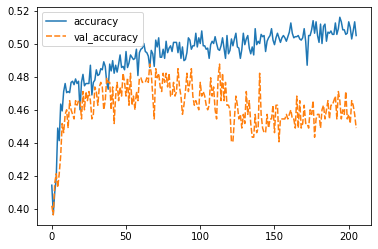

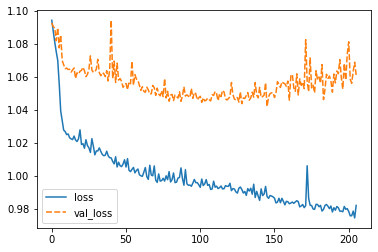

In [38]:
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)


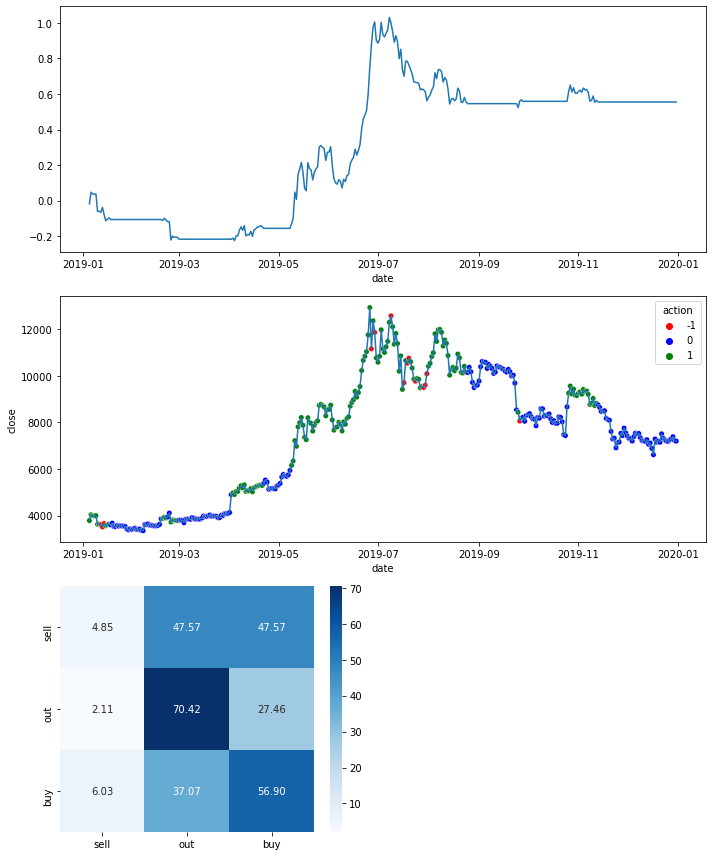

In [46]:
y_pred = model.predict(x_test)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)

Evaluator.evaluate(y_pred_labeled, y_test_labeled, df_candle_y, force=False)

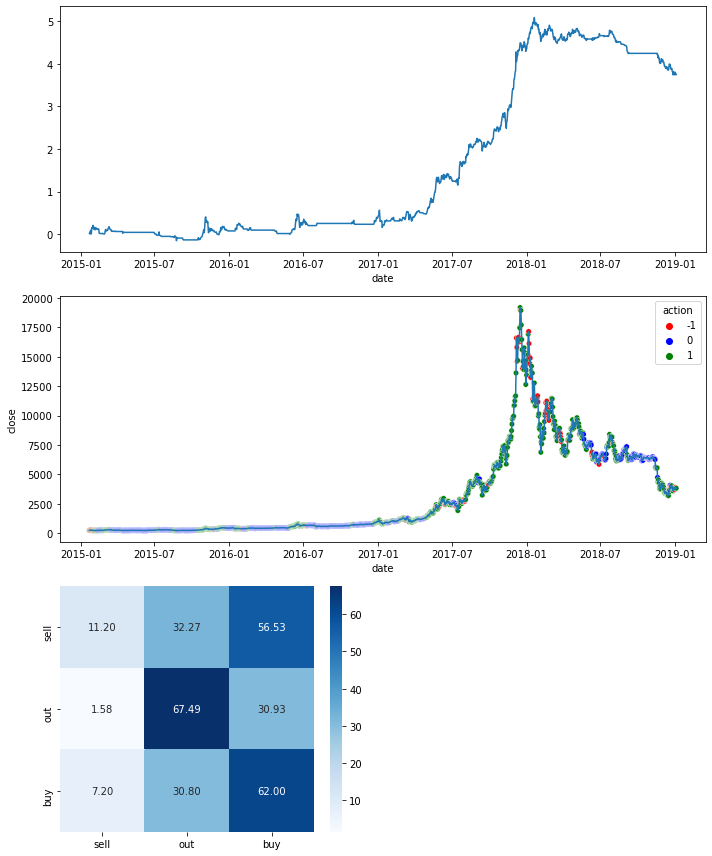

In [40]:
y_predt = model.predict(x_train)
y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=x_index)
y_predt_labeled = y_predt_labeled.idxmax(axis=1)

Evaluator.evaluate(y_predt_labeled, y_train_labeled, df_candle_x, force=False)

In [ ]:
print(classification_report(y_test_labeled, y_pred_labeled))

In [ ]:
#test
temp =  {'train_accuracy':[], 'train_f1':[], 'test_accuracy':[], 'test_f1':[]}

for i in range(10):
    model = get_model_both_sent()
    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=0, patience=60)
    mc = ModelCheckpoint('model_pp.h5',verbose=0, save_best_only=True,)
    history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=32,
                        epochs=300, callbacks=[mc, es], verbose=0)

    model = load_model('model_pp.h5')
    y_pred = model.predict(x_test)
    y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_index)
    y_pred_labeled = y_pred_labeled.idxmax(axis=1)
    y_predt = model.predict(x_train)
    y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=x_index)
    y_predt_labeled = y_predt_labeled.idxmax(axis=1)
    results_test = classification_report(y_test_labeled, y_pred_labeled, output_dict=True)
    temp['test_accuracy'].append(results_test['accuracy'])
    temp['test_f1'].append(results_test['weighted avg']['f1-score'])
    results_test = classification_report(y_train_labeled, y_predt_labeled, output_dict=True)
    temp['train_accuracy'].append(results_test['accuracy'])
    temp['train_f1'].append(results_test['weighted avg']['f1-score'])
temp

In [ ]:
import statistics

print(statistics.mean(temp['train_f1']))
print(statistics.mean(temp['test_f1']))
print(statistics.mean(temp['train_accuracy']))
print(statistics.mean(temp['test_accuracy']))

In [ ]:
plt.figure(figsize=(10,5))
for i in range(5):
    model = get_model_both_sent()
    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=0, patience=60)
    mc = ModelCheckpoint('model_pp.h5',verbose=0, save_best_only=True,)
    history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=32,
                        # class_weight=class_weights,
                        epochs=300, callbacks=[mc, es], verbose=0)

    model = load_model('model_pp.h5')
    y_pred = model.predict(x_test)
    y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_index)
    y_pred_labeled = y_pred_labeled.idxmax(axis=1)
    pnl = Evaluator.get_pnl(y_pred_labeled, df_candle_y)
    sb.lineplot(x=pnl.index, y=pnl)